Importuri necesare

In [9]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import xgboost as xgb

import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

Verificam dimensiunile pozelor (daca este nevoie de resize la aceasi dimensiune)

In [2]:
dimensiuni = {}
path = "data/train"
for file in os.listdir(path):
    if file.lower().endswith('.png'):
        img_path = os.path.join(path, file)
        with Image.open(img_path) as img:
            dimensiuni[file] = img.size

dimensiuni_unice = set(dimensiuni.values())

if len(dimensiuni_unice) == 1:
    print("Toate pozele au aceasi dimensiune: ", dimensiuni_unice.pop())

else:
    print("Dimensiunile gasite sunt: ")
    for dimensiune in dimensiuni_unice:
        print(dimensiune)


Toate pozele au aceasi dimensiune:  (100, 100)


Verificam daca exista poze alb negru

In [3]:
def veirifcare_alb_negru(image_path):
    with Image.open(image_path) as poza:
        if poza.mode in ('L', '1'):
            return True
        if poza.mode == 'RGB':
            poza_np = np.array(poza)
            return np.all(poza_np[:,:,0] == poza_np[:,:,1]) and np.all(poza_np[:,:,1] == poza_np[:,:,2])

def loader_poze(path):
    cnt = 0
    for fisier in os.listdir(path):
        if fisier.lower().endswith('.png'):
            fisier_path = os.path.join (path, fisier)
            if veirifcare_alb_negru(fisier_path):
                print(f'{fisier} este alb negru.')
                cnt += 1
    if cnt == 0:
         print("Nu exista outliers, toate pozele sunt color")


path = 'data/train'
loader_poze(path)

Nu exista outliers, toate pozele sunt color


Calculam media si deviatia standard

In [10]:
def media_si_deviatia_standard(folder_path):
    sum_culori = np.zeros(3, dtype=np.float64)
    sum_culori_la_patrat = np.zeros(3, dtype=np.float64)
    nr_pixeli = 0

    for nume_fisier in os.listdir(folder_path):
        imagine = cv2.imread(os.path.join(folder_path, nume_fisier))

        if imagine is not None:
            poza_in_float = imagine.astype(np.float64)

            sum_culori += np.sum(poza_in_float, axis=(0, 1))
            sum_culori_la_patrat += np.sum(np.square(poza_in_float), axis=(0, 1))
            nr_pixeli += poza_in_float.shape[0] * poza_in_float.shape[1]

    media = sum_culori / nr_pixeli
    deviatia_standard = np.sqrt((sum_culori_la_patrat / nr_pixeli) - np.square(media))

    return media, deviatia_standard

path = "data/train"

media, deviatia_standard = media_si_deviatia_standard(path)

print(media_si_deviatia_standard(path))

(array([105.74419194, 117.83061714, 121.2949136 ]), array([71.68637746, 69.16595101, 69.32370149]))


Normalizam pozele pe baza mediei si a deviatiei standard

In [ ]:
media = np.array([105.74, 117.83, 121.29])
deviatia_standard = np.array([71.68, 69.16, 69.32])

def normalizare(imagine, media, deviatia_standard):
    imagine_float = imagine.astype(np.float64)
    normalizata = (imagine_float - media) / deviatia_standard
    return normalizata

def procesare(path, path_iesire, media, deviatia_standard):
    for imagine in os.listdir(path):
        imagine_full = cv2.imread(os.path.join(path, path_iesire))
        normalizata = normalizare(imagine_full, media, deviatia_standard)

        fisier_output = os.path.splitext(file)[0] + ".npy"
        path_output = os.path.join(path_iesire, fisier_output)
        np.save(path_output, normalizata)

folder = "data/test"
path_iesire = "data/test_normalised"

procesare(folder, path_iesire, media, deviatia_standard)

Incarcam pozele normalizate in format .npy pentru antrenare si teste

In [10]:
def data_loader(csv_path, img_path):
    df = pd.read_csv(csv_path)

    images = []
    labels = []

    for index, row in df.iterrows():
        image_id = str(row['image_id']) + ".npy"
        label = row['label']

        image_path = os.path.join(img_path, image_id)

        image = np.load(image_path)

        image = image.flatten()

        images.append(image)

        labels.append(label)

    return np.array(images), np.array(labels)

img_path = "data/train_normalised"

csv_path = "data/train.csv"

images_train, labels_train = data_loader(csv_path, img_path)

img_path = "data/validation_normalised"

csv_path = "data/validation.csv"

images_validation, labels_validation = data_loader(csv_path, img_path)

Incarcam pozele NEnormalizate in format .png pentru teste

In [13]:
def data_loader(csv_path, img_path):
    df = pd.read_csv(csv_path)

    images = []
    labels = []

    for inder, row in df.iterrows():
        image_id = str(row['image_id']) + ".png"
        label = row['label']

        image_path = os.path.join(img_path, image_id)
        image = cv2.imread(image_path)

        image = image.flatten()

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

img_path = "data/train"

csv_path = "data/train.csv"

images_train, labels_train = data_loader(csv_path, img_path)

img_path = "data/validation"

csv_path = "data/validation.csv"

images_validation, labels_validation = data_loader(csv_path, img_path)

Un model simplu de Random Forest, scopul a fost drept experiment

In [17]:
copaceii = RandomForestClassifier(n_estimators = 1000, max_depth = 20, random_state = 42)

copaceii.fit(images_train, labels_train)

predictions = copaceii.predict(images_validation)

print(accuracy_score(labels_validation, predictions))

print(confusion_matrix(labels_validation, predictions))

KeyboardInterrupt: 

Un model simplu de SVM, scopul a fost drept experiment

In [ ]:
svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=False, verbose=True)

svm_model.fit(images_train, labels_train)

predictions = svm_model.predict(images_validation)

accuracy = accuracy_score(labels_validation, predictions)

print(accuracy)

print(classification_report(labels_validation, accuracy))

print(confusion_matrix(labels_validation, accuracy))

Ambele rezultate au fost slabe, deci am decis sa folosesc o retea convolutionala.
Indiferent de finetuning-ul pe care il faceam la modele nu aveam cum sa cresc rezultatele pe cat imi as fi sperat

Aici am definit mai multe variante de retele convolutionale pe care le-am utilizat in timpul experimentelor

In [ ]:
# acest model a obtinut 91% acuratete (cred) la validare fara data augmentation

# retea = models.Sequential([
#
#     layers.InputLayer(shape=(img_h, img_w, nr_channels)),
#
#     layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.Conv2D(32, (3, 3)), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization()
#     layers.MaxPooling2D(pool_size = (2, 2)),
#     layers.Dropout(0.25),
#
#     layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size = (2, 2)),
#     layers.Dropout(0.3)
#
#     layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size = (2, 2)),
#     layers.Dropout(0.35)
#
#     layers.FLatten(),
#     layers.Dense(256, activation = 'relu),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(nr_classes, activation = 'softmax')
# ])

# acest model a fost cel mai simplu model incercat
# retea = models.Sequential([
#
#     layers.InputLayer(shape=(img_h, img_w, nr_channels)),
#
#     layers.Conv2D(16, (5, 5), activation = 'relu', padding = 'same'),
#     layers.MaxPooling2D(pool_size = (4, 4)),
#     layers.BatchNormalization(),
#
#     layers.Conv2D(32, (5, 5), activation = 'relu', padding = 'same'),
#     layers.MaxPooling2D(pool_size = (4, 4)),
#     layers.BatchNormalization(),
#
#
#     layers.FLatten(),
#     laters.Dense(32, activation = 'relu'),
#     layers.Dropout(0.25)
#     layers.Dense(nr_classes, activation = 'softmax')
# ])


# cel mai puternic model, care facea si cel mai mare overfit fara data augmentation


# retea = models.Sequential([
#     layers.InputLayer(shape=(img_h, img_w, nr_channels)),
#     layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu')
#     layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu')
#     layers.MaxPooling2D(pool_size = (3, 3)),
#     layers.Dropout(0.3)
#
#     layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu')
#     layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu')
#     layers.MaxPooling2D(pool_size = (2, 2)),
#     layers.Dropout(0.3)
#
#     layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu')
#     layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu')
#     layers.MaxPooling2D(pool_size = (2, 2)),
#     layers.Dropout(0.3)
#
#     layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu')
#     layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu')
#     layers.MaxPooling2D(pool_size = (2, 2)),
#     layers.Dropout(0.3)
#
#     layers.Flatten()
#     layers.Dense(512, activation  ='relu'
#     layers.BatchNormalization()
#     layers.Dropout(0.5)
#     layers.dense(nr_classes, activation = 'softmax')
# ])

#
# model = models.Sequential([
#     layers.InputLayer(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)),
#     layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Dropout(0.3),
#     layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Dropout(0.4),
#     layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Dropout(0.5),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ///////////////////////////
#
#     layers.InputLayer(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)),
#     layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Dropout(0.3),
#
#     layers.Conv2D(96, (3, 3), padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.Conv2D(96, (3, 3), padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Dropout(0.4),
#
#     layers.Conv2D(192, (3, 3), padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Dropout(0.5),
#
#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(NUM_CLASSES, activation='softmax')

Codul "complet" pentru antrenarea unei retele convolutionale cu cateva explicatii unde am considerat ca este cazul

In [18]:
img_h = 100
img_w = 100
nr_channels = 3
nr_classes = 5

batches = 32
epochs = 10 #in alte iteratii o sa ajunga si 150-200 depinde de retea

# aici puteam modifica "greutatile" de asemene, dar deoarece setul nostru de date este perfect echilibrat, nu a fost necesar
# avem 12500 de poze, si 2500 pentru fiecare eticheta

# aplatizam imaginile pentru ca putem folosi straturi dense (nu mereu dar e bine sa ramana aici)
images_train_flat = images_train.reshape(-1, img_h, img_w, nr_channels)
images_validation_flat = images_validation.reshape(-1, img_h, img_w, nr_channels)

# folosim one hot encodingla label-uri pentru a prezenta probabilitatea de a alege o clasa
labels_train_hot = to_categorical(labels_train, num_classes = nr_classes)
labels_validation_hot = to_categorical(labels_validation, num_classes = nr_classes)

# pentru variant
retea = models.Sequential([

    layers.InputLayer(shape=(img_h, img_w, nr_channels)),

    # x = layers.RandomFlip("horizontal", name="random_flip")(inputs)
    # x = layers.RandomRotation(0.05, name="random_rotation")(x)
    # x = layers.RandomZoom(0.05, name="random_zoom")(x)

    # cateva modetode de data augmentation care nu au fost de succes


    layers.Conv2D(24, (7, 7), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size = (2, 2)),

    layers.Conv2D(48, (5, 5), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size = (2, 2)),

    layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size = (2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),

    layers.Dense(nr_classes, activation = 'softmax')
])

retea.summary()

retea.compile(optimizer = 'adam', #exista si varianta adamh care e posibil sa fie mai buna dar nu am experimentat cu aceasta
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# definim callbacks si parametrii acestora

checkpoint = ModelCheckpoint(
    filepath = 'model.keras',
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 15,
    verbose = 1,
    restore_best_weights = True
)

reduce_learning = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 7,
    verbose = 1,
    min_lr = 0.0001 #posibil sa fie prea mare si sa trebuiasca sa il scad
)

list_of_callbacks = [checkpoint, stopping, reduce_learning]

history = retea.fit(images_train_flat, labels_train_hot,
                    validation_data = (images_validation_flat, labels_validation_hot),
                    epochs = epochs,
                    batch_size = batches,
                    callbacks = list_of_callbacks
                    )

model_x = models.load_model('model.keras')





2025-06-09 20:27:26.525565: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-06-09 20:27:26.532834: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-09 20:27:26.533033: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-09 20:27:26.533575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-09 20:27:26.534238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 24)   │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 24)   │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 48)     │        28,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,981 (238.21 KB)

 Trainable params: 60,709 (237.14 KB)

 Non-trainable params: 272 (1.06 KB)

Epoch 1/10


2025-06-09 20:27:33.547062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5851 - loss: 1.0450
Epoch 1: val_accuracy improved from -inf to 0.71920, saving model to model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.5852 - loss: 1.0446 - val_accuracy: 0.7192 - val_loss: 0.7011 - learning_rate: 0.0010
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7191 - loss: 0.7213
Epoch 2: val_accuracy improved from 0.71920 to 0.75360, saving model to model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.7191 - loss: 0.7213 - val_accuracy: 0.7536 - val_loss: 0.6506 - learning_rate: 0.0010
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7523 - loss: 0.6520
Epoch 3: val_accuracy improved from 0.75360 to 0.76960, saving model to model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.7523 - loss: 0.6519 - val_accuracy: 0.7696 - val_loss: 0.5910 - learning_rate: 0.0010
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7758 

Dupa mai multe teste, am ajuns la concluzia ca primele 3 clase sunt confundate cu cea de a 4-a clasa, deci am decis sa mai fac cateva teste. Primul test a fost de a verifica canalele de culoare RGB, dupa HSV si dupa LAB pentru a incerca sa inteleg culorile. Motivul pentru care am luat aceasta decizie a fost cauzat de performanta ridicata a Random Forest (70%) avand in vedere ca se facea doar pe pixeli individual.

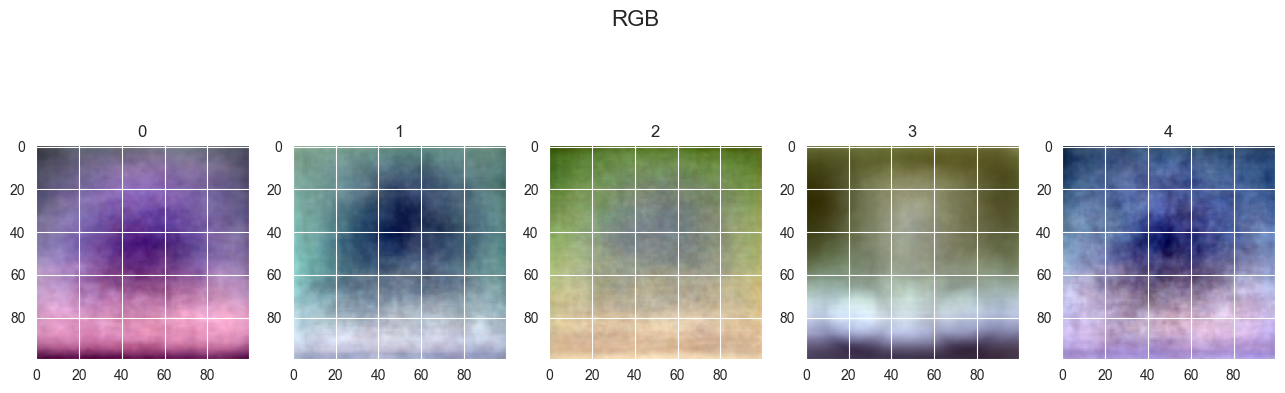

In [26]:
medie_poze = []

# calculam media pentru fiecare clasa
for i in range(nr_classes):
    clasa_poze = images_train_flat[labels_train == i]
    medie_poza = np.mean(clasa_poze, axis = 0)
    medie_poze.append(medie_poza)

out, ax = plt.subplots(1, nr_classes, figsize = (16, 5))


for i in range(nr_classes):
    afis = medie_poze[i]


    # a trebuit sa realizam aceasta normalizare, deoarece nu erau evidentiate culorile atat de bine
    val_min, val_max = afis.min(), afis.max()
    if val_max > val_min:
        afis = (afis - val_min) / (val_max - val_min)

    ax[i].imshow(afis)
    ax[i].set_title(i)


# la afisare, avem cate o poza pentru fiecare clasa
plt.suptitle('Canale RGB', fontsize = 16)
plt.show()

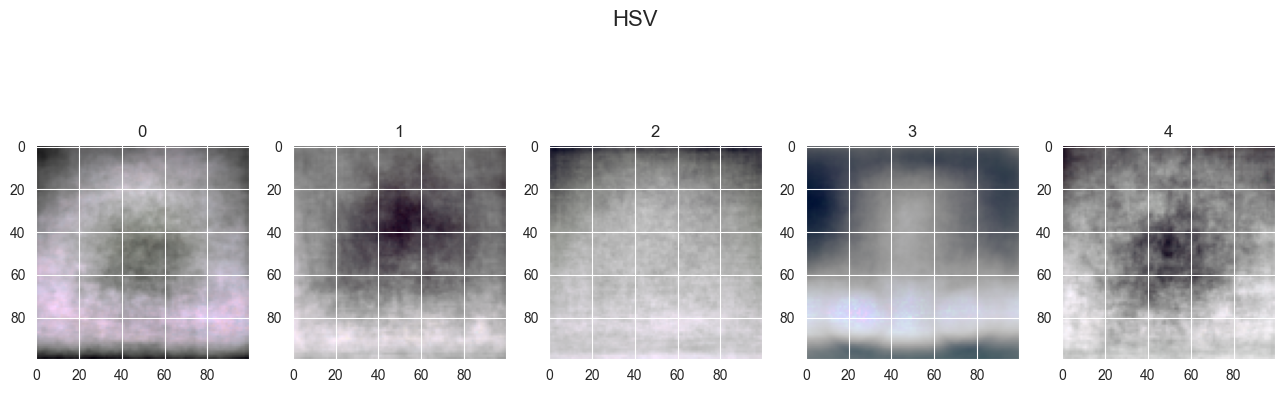

In [31]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def medie(poze):
    if len(poze) == 0:
        return np.zeros((img_h, img_w, nr_channels))

    # separarea canalelor H, S si V
    hue = poze[:, :, :, 0]
    saturation = poze[:, :, :, 1]
    values = poze[:, :, :, 2]

    # calculam media

    rad_hue = hue * 2 * np.pi #convertim de la 0-1 la radiani 0-2*pi

    # convertim in coordonate carteziene
    x = np.cos(rad_hue)
    y = np.sin(rad_hue)

    # calculam media verctorilor
    mean_x = np.mean(x, axis = 0)
    mean_y = np.mean(y, axis = 0)

    # convertim media la radiani
    mean_hue_rad = np.arctan2(mean_y, mean_x)

    # convertim inapoi la 0-1
    mean_hue = (mean_hue_rad % (2 * np.pi)) / (2 * np.pi)

    # calculam media pentru saturation si value
    mean_saturation = np.mean(saturation, axis = 0)
    mean_value = np.mean(values, axis = 0)

    # combinam datele
    mean_hsv_image = np.stack([mean_hue, mean_saturation, mean_value], axis = -1)

    return mean_hsv_image

mean_hsv_images = []

for i in range(nr_classes):
    class_hsv_images = images_train_flat[labels_train == i]
    mean_hsv = medie(class_hsv_images)
    mean_hsv_images.append(mean_hsv)

# transformam pozele rezultatele din hsv in rgb pentru afisare
mean_rgb = [tf.image.hsv_to_rgb(img).numpy() for img in mean_hsv_images]

out, ax = plt.subplots(1, nr_classes, figsize = (16, 5))


for i in range(nr_classes):
    afis = mean_rgb[i]

    val_min, val_max = afis.min(), afis.max()
    if val_max > val_min:
        afis = (afis - val_min) / (val_max - val_min)

    ax[i].imshow(afis)
    ax[i].set_title(i)

plt.suptitle('HSV', fontsize=16)
plt.show()

/var/folders/l6/wgp1p_wx061_yyrh6v0x_zx00000gn/T/ipykernel_9938/2661953576.py:11: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1851 negative Z values that have been clipped to zero
  return lab2rgb(mean_lab)


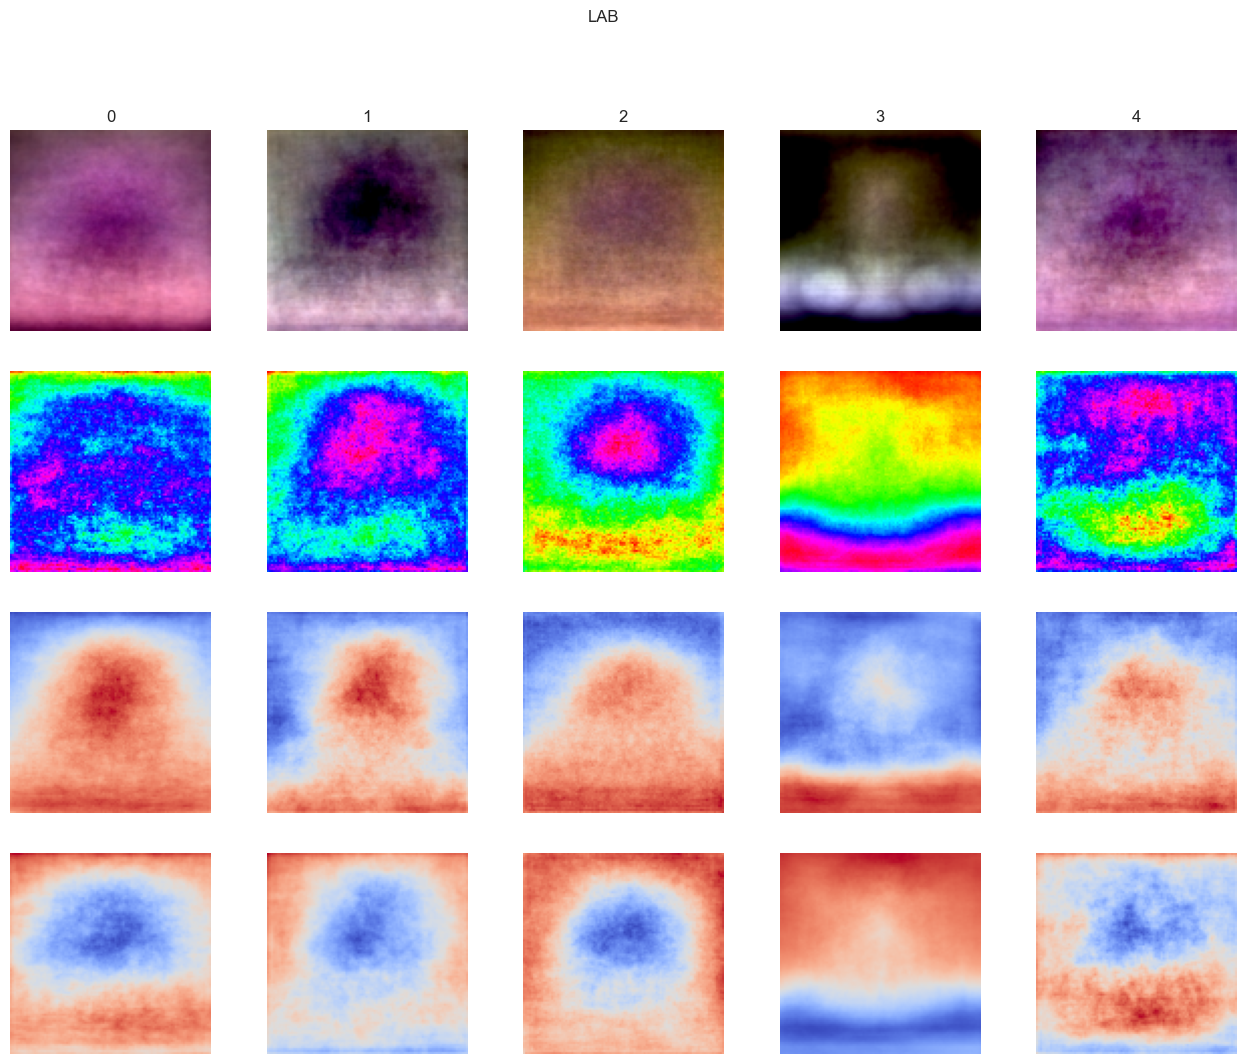

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb, rgb2hsv

def medie_lab_in_rgb(images):

    lab_images = np.array([rgb2lab(img) for img in images])
    if len(images) == 0:
        return np.zeros((100, 100, 3))
    mean_lab = np.mean(lab_images, axis = 0)
    return lab2rgb(mean_lab)

def medie_canal(images, color_space = 'hsv', channel_id = 0):

    if len(images) == 0:
        return np.zeros((100,100))

    if color_space == 'hsv' :
        converted_images = np.array([rgb2hsv(img) for img in images])

    elif color_space == 'lab':
        converted_images = np.array([rgb2lab(img) for img in images])

    else:
        return np.zeros((100,100))

    return np.mean(converted_images[:, :, :, channel_id], axis = 0)

med_lab_rgb_img = []
med_hue_channels = []
med_a_star_channels = []
med_b_star_channels = []

for i in range(nr_classes):
    class_images = images_train_flat[labels_train == i]

    med_lab_rgb_img.append(medie_lab_in_rgb(class_images))
    med_hue_channels.append(medie_canal(class_images, 'hsv', 0))
    med_a_star_channels.append(medie_canal(class_images, 'lab', 1))
    med_b_star_channels.append(medie_canal(class_images, 'lab', 2))

out, ax = plt.subplots(4, nr_classes, figsize = (16, 12))
out.suptitle('LAB')


data = [
    med_lab_rgb_img,
    med_hue_channels,
    med_a_star_channels,
    med_b_star_channels
]

data_n = [None, 'hsv', 'coolwarm', 'coolwarm']

for r, rr in enumerate(data):
    for col in range(nr_classes):
        afis = rr[col]
        val_min, val_max = afis.min(), afis.max()
        if val_max > val_min:
            afis = (afis - val_min) / (val_max - val_min)

        ax[r, col].imshow(afis, cmap = data_n[r])
        ax[r, col].axis('off')

        if r == 0:
            ax[r, col].set_title(col)

plt.show()

Am incercat sa antrenez un model de XGBoost pe baza histogramelor de culori, dar rezultatele au lasat de dorit

In [ ]:
def histograme(image_set, n_bins = 32):

    histograms = []

    for img in image_set:
        hist_features = np.concatenate([
            np.histogram(img[:, :, 0], bins = n_bins, range = [0,256]) [0],
            np.histogram(img[:, :, 1], bins = n_bins, range = [0,256]) [0],
            np.histogram(img[:, :, 2], bins = n_bins, range = [0,256]) [0],
        ])

        if hist_features.sum() > 0:
            hist_features = hist_features / hist_features.sum()

        histograms.append(hist_features)
    return np.array(histograms)

images_train_reshaped = images_train_flat.reshape(-1, 100, 100, 3)

train_hist = histograme(images_train_reshaped)

images_validation_reshaped = images_validation_flat.reshape(-1, 100, 100, 3)

validation_hist = histograme(images_validation_reshaped)

model = xgb.XGBClassifier(
    objective = 'multi:softmax',
    num_class = len(np.unique(labels_train)),
    n_estimators = 350,
    learning_rate = 0.15,
    max_depth = 7,
    use_label_encoder = False,
    eval_metric = 'mlogloss'
)

model.fit(train_hist, labels_train)

predictions = model.predict(validation_hist)

print(classification_report(labels_validation, predictions))

matrice = confusion_matrix(labels_validation, predictions)
plt.show

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, nr_classes, figsize=(15, 4))

for i in range(nr_classes):
    # Calculează imaginea medie pentru clasa curentă
    mean_image = np.mean(images_train[labels_train == i], axis=0)

    # Normalizează imaginea medie la intervalul [0, 1] pentru afișare
    min_val, max_val = mean_image.min(), mean_image.max()
    if (max_val - min_val) > 0:
        normalized_image = (mean_image - min_val) / (max_val - min_val)
    else:
        normalized_image = mean_image

    # Afișează imaginea normalizată
    axes[i].imshow(normalized_image)
    axes[i].set_title(i)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Codul pentru definirea functiei de cutout (data augmentation)

Am revenit la reteaua convolutionala si am incercat o metoda noua de Data Augmentation, aceea fiind cutout. Dupa ce am experimentat cu aceasta am descoperit pe internet si cutmix, metoda cu care am obtinut rezultate si mai bune

In [13]:
def cutout(image):
    h = tf.cast(img_h * 0.25, dtype = tf.int32)
    w = tf.cast(img_w * 0.25, dtype = tf.int32)

    cy = tf.random.uniform([], 0, img_h, dtype = tf.int32)
    cx = tf.random.uniform([], 0, img_w, dtype = tf.int32)

    y1 = tf.clip_by_value(cy - h // 2, 0, img_h)
    y2 = tf.clip_by_value(cy + h // 2, 0, img_h)
    x1 = tf.clip_by_value(cx - w // 2, 0, img_h)
    x2 = tf.clip_by_value(cx - w // 2, 0, img_h)

    mask = tf.ones_like(image)
    padding = [[y1, img_h - y2], [x1, img_w - x2], [0, 0]]
    cutout_region = tf.zeros([y2 - y1, x2 - x1, nr_channels])

    mask_cutout_part = tf.pad(cutout_region, padding, "CONSTANT", constant_values = 1)
    mask = mask - 1,(1 - mask_cutout_part)

    return image*mask

# apelul se face prin adaugarea urmatoarei functii lambda la layer
#
# layers.Lambda(lambda x: tf.map_fn(custom_cutout, x))
#
#

In [15]:
def cutmix(images, labels, prob=1.0, alpha=1.0):

    batch_size = tf.shape(images)[0]
    img_h = tf.shape(images)[1]
    img_w = tf.shape(images)[2]

    do_cutmix = tf.random.uniform([]) < prob
    if not do_cutmix:
        return images, labels

    shuffled_indices = tf.random.shuffle(tf.range(batch_size))
    images_shuffled = tf.gather(images, shuffled_indices)
    labels_shuffled = tf.gather(labels, shuffled_indices)

    lam = tf.compat.v1.distributions.Beta(alpha, alpha).sample()

    ratio = tf.sqrt(1.0 - lam)
    patch_h = tf.cast(ratio * tf.cast(img_h, tf.float32), dtype=tf.int32)
    patch_w = tf.cast(ratio * tf.cast(img_w, tf.float32), dtype=tf.int32)

    cy = tf.random.uniform([], maxval=img_h, dtype=tf.int32)
    cx = tf.random.uniform([], maxval=img_w, dtype=tf.int32)

    y1 = tf.clip_by_value(cy - patch_h // 2, 0, img_h)
    y2 = tf.clip_by_value(cy + patch_h // 2, 0, img_h)
    x1 = tf.clip_by_value(cx - patch_w // 2, 0, img_w)
    x2 = tf.clip_by_value(cx + patch_w // 2, 0, img_w)

    patch = tf.ones([y2 - y1, x2 - x1, 1], dtype=tf.float32)

    padding = [[y1, img_h - y2], [x1, img_w - x2], [0, 0]]
    mask_single = tf.pad(patch, padding, "CONSTANT", constant_values=0)

    mask = 1.0 - tf.tile(tf.expand_dims(mask_single, 0), [batch_size, 1, 1, 1])

    mixed_images = images * mask + images_shuffled * (1.0 - mask)

    lam_adjusted = 1.0 - (tf.cast((x2 - x1) * (y2 - y1), tf.float32) / tf.cast(img_h * img_w, tf.float32))
    mixed_labels = labels * lam_adjusted + labels_shuffled * (1.0 - lam_adjusted)

    return mixed_images, mixed_labels


# Now, your data pipeline call should work correctly
# train_pipeline = (
#     train_dataset
#     .shuffle(1024)
#     .batch(batches)
#     .map(lambda img, lbl: cutmix(img, lbl, prob=1.0), num_parallel_calls=autotune)
#     .prefetch(autotune)
# )


Varianta finala prin care am antrenat modelul (nu stiu sigur daca asta a fost structura retelei, dar restul codului ramane la fel)

In [21]:
img_h = 100
img_w = 100
nr_channels = 3
nr_classes = 5

batches = 32
epochs = 100

images_train_float32 = images_train.astype('float32')
images_validation_float32 = images_validation.astype('float32')

labels_train_hot_temp = to_categorical(labels_train, num_classes=nr_classes)
labels_validation_hot_temp = to_categorical(labels_validation, num_classes=nr_classes)

labels_train_hot = labels_train_hot_temp.astype('float32')
labels_validation_hot = labels_validation_hot_temp.astype('float32')


retea = models.Sequential([
    layers.InputLayer(shape=(img_h, img_w, nr_channels)),
    #
    # asa se realizeaza apelul la cutout
    # layers.Lambda(lambda x: tf.map_fn(custom_cutout, x)),
    #
    layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(96, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(96, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(192, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(192, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),

    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(nr_classes, activation='softmax')
])

retea.summary()

retea.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

checkpoint = ModelCheckpoint(
    filepath = 'model.keras',
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 15,
    verbose = 1,
    restore_best_weights = True
)

reduce_learning = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 7,
    verbose = 1,
    min_lr = 0.0001
)

list_of_callbacks = [checkpoint, stopping, reduce_learning]


autotune = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((images_train_flat, labels_train_hot))

train_pipeline = (
    train_dataset
    .shuffle(1024)
    .batch(batches)
    .map(lambda img, lbl: cutmix(img, lbl, prob=1.0), num_parallel_calls=autotune)
    .prefetch(autotune)
)

validation_pipeline = (
    tf.data.Dataset.from_tensor_slices((images_validation_flat, labels_validation_hot))
    .batch(batches)
    .prefetch(autotune)
)

history = retea.fit(
    train_pipeline,
    validation_data=validation_pipeline,
    epochs=epochs,
    callbacks=list_of_callbacks
)

model_x = models.load_model('model.keras')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ (None, 100, 100, 48)   │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 100, 100, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 100, 100, 48)   │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 100, 100, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 50, 50, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 50, 50, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 50, 50, 96)     │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 50, 50, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 50, 50, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 50, 50, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 25, 25, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 25, 25, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 25, 25, 192)    │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 25, 25, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 25, 25, 192)    │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 25, 25, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 12, 12, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 12, 12, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 12, 12, 512)    │       885,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 12, 12, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,439,413 (28.38 MB)

 Trainable params: 7,435,509 (28.36 MB)

 Non-trainable params: 3,904 (15.25 KB)

TypeError: in user code:

    File "/var/folders/l6/wgp1p_wx061_yyrh6v0x_zx00000gn/T/ipykernel_24222/797802170.py", line 104, in None  *
        lambda img, lbl: cutmix(img, lbl, prob=1.0)
    File "/var/folders/l6/wgp1p_wx061_yyrh6v0x_zx00000gn/T/ipykernel_24222/3623039375.py", line 39, in cutmix  *
        mixed_labels = labels * lam_adjusted + labels_shuffled * (1.0 - lam_adjusted)

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float64 of argument 'x'.


In [ ]:
model = load_model('model.keras')
df_test = pd.read_csv('data/test.csv')

image_ids = []
predicted_labels = []

for index, row in df_test.iterrows():
    image_name = str(row['image_id'])
    image_path = os.path.join('data/test_normalised', image_name + '.npy')

    image_array = np.load(image_path)
    image_batch = np.expand_dims(image_array, axis=0)

    prediction = model.predict(image_batch, verbose=0)
    predicted_class = np.argmax(prediction, axis=1)[0]

    image_ids.append(image_name)
    predicted_labels.append(predicted_class)

df_results = pd.DataFrame({
    'image_id': image_ids,
    'label': predicted_labels
})

df_results.to_csv('results.csv', index=False)